LSTM İle Hisse Senedi Fiyatı Tahminlemesi

Problem Nedir?
Teslaya ait geçmiş yıllara dayanan hisse senedi verileriyle gelecekteki hisse senedi kapanış fiyatını tahmin etme

Date = işlem gününün tarihi

Open = İşlem gününe ait hiise başlangıç fiyatı

High = İşlem gününe ait en yüksek fiyatlı temsil eder.

Low = işlem gününe ait en düşük fiyatı temsil eder.

Close =  işlem gününde hisse senedinin kapanış fiyatını temsil etmektedir.

Adj Close = İlgili işlem gününe ait hisse senedinin düzenlenmiş kapanış fiyatını temsil eder.

Volume = ilgili işlem gününe ait işlem hacim bilgisini temsil eder.

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

#model değerlendirme ve veriyi scale etme için
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

#tf warningleri engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [ ]:
df = pd.read_csv('/content/TSLA.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


Veri Hazırlama

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [ ]:
df["Date"]=pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2416 non-null   datetime64[ns]
 1   Open       2416 non-null   float64       
 2   High       2416 non-null   float64       
 3   Low        2416 non-null   float64       
 4   Close      2416 non-null   float64       
 5   Adj Close  2416 non-null   float64       
 6   Volume     2416 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 132.2 KB


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
tesla_df = df[["Date","Close"]]
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [ ]:
print("Minimum Tarihi :", tesla_df["Date"].min())
print("Maksimum Tarihi :", tesla_df["Date"].max())

Minimum Tarihi : 2010-06-29 00:00:00
Maksimum Tarihi : 2020-02-03 00:00:00


In [ ]:
tesla_df.index = tesla_df["Date"]
tesla_df.head()

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001


In [ ]:
tesla_df.drop("Date",axis=1,inplace=True)


In [ ]:
result_df = tesla_df.copy()

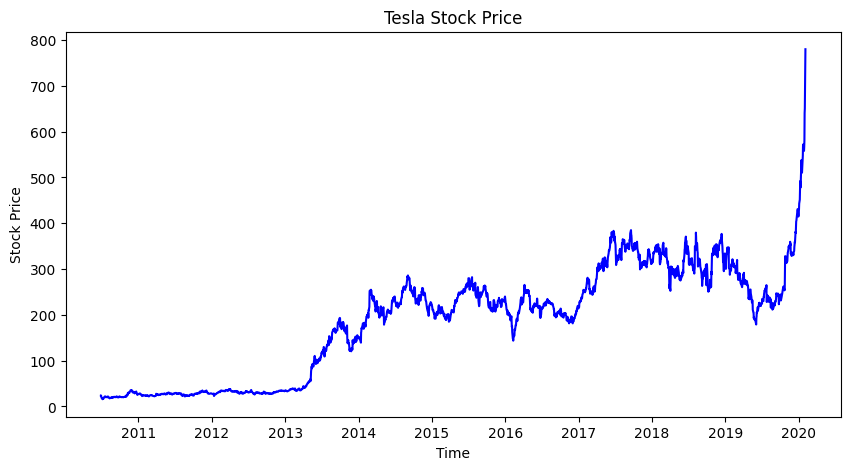

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(tesla_df['Close'],color='blue');
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()

In [ ]:
tesla_df = tesla_df.values


In [ ]:
tesla_df[:9]
tesla_df = tesla_df.astype('float32')

In [ ]:
#trai-test ayrımı
def split_data(dataframe,test_size):
  position = int(round(len(dataframe)*(1-test_size)))
  train_data = dataframe[:position]
  test_data = dataframe[position:]
  return train_data,test_data,position

In [ ]:
train_data,test_data,position = split_data(tesla_df,0.2)

In [ ]:
print(train_data.shape,test_data.shape)

(1933, 1) (483, 1)


In [ ]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train_data)

In [ ]:
scaler_test = MinMaxScaler(feature_range=(0,1))
test= scaler_test.fit_transform(test_data)

In [ ]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [ ]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [ ]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [ ]:
lookback=20

In [ ]:
X_train,y_train = create_features(train,lookback)
#Test Veri Seti
X_test,y_test= create_features(test,lookback)

In [ ]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Modelleme

In [ ]:
model=Sequential()
model.add(LSTM(units=50,activation='relu',input_shape= (X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
             ModelCheckpoint(filepath='mymodel3.keras',monitor='val_loss',save_best_only=True,save_weights_only=False,verbose=1,mode='min')]

In [ ]:
history=model.fit(x = X_train,
                  y= y_train,
                  epochs = 100,
                  batch_size=20,
                  validation_data=(X_test,y_test),
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/100
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 1: val_loss improved from inf to 0.00401, saving model to mymodel3.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 2/100
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 2: val_loss improved from 0.00401 to 0.00291, saving model to mymodel3.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 3/100
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 3: val_loss improved from 0.00291 to 0.00277, saving model to mymodel3.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 4/100
73/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 4: val_loss improved from 0.00277 to 0.00238, saving model to mymodel3.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 5/100
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 5: val_loss did not improve from 0.00238
96/

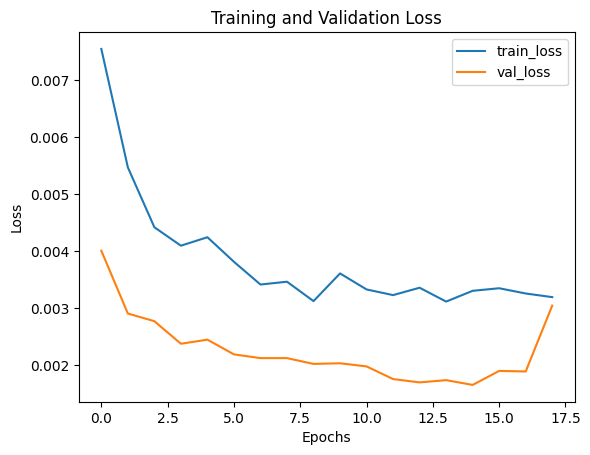

In [ ]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print("Test loss:%.1f%%" % (100.0 * loss))

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032
Test loss:0.3%


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [ ]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [ ]:
#train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
#test veri setine ait RMSE dğeri
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [ ]:
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:15.023118019104004
Test RMSE:33.16749954223633


In [ ]:
train_prediction_df=result_df[lookback:position]

In [ ]:
train_prediction_df['Prediction'] = train_predict

In [ ]:
train_prediction_df.head()

,Close,Prediction
Date,,
2010-07-28,20.719999,36.808372
2010-07-29,20.350000,36.825539
2010-07-30,19.940001,36.808331
2010-08-02,20.920000,36.808331
2010-08-03,21.950001,36.841347


In [ ]:
test_prediction_df=result_df[position+lookback:] # Change made here
test_prediction_df["Prediction"]=test_predict
test_prediction_df.head()

,Close,Prediction
Date,,
2018-04-03,267.529999,319.964691
2018-04-04,286.940002,314.627625
2018-04-05,305.720001,314.757416
2018-04-06,299.299988,318.538177
2018-04-09,289.660004,318.892456


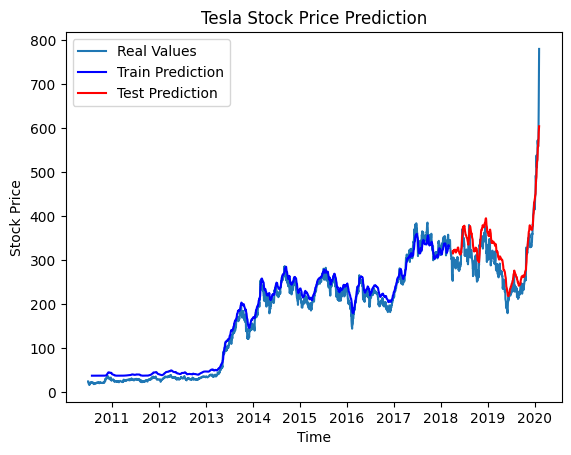

In [ ]:
plt.plot(result_df,label="Real Values")
plt.plot(train_prediction_df['Prediction'],label="Train Prediction",color='blue')
plt.plot(test_prediction_df['Prediction'],label="Test Prediction",color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.show()